In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn.functional as F
import torchvision
from torch import nn

from utils import CUDA, VGG, to_np, to_tensor

In [2]:
![ -e ../data/images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O ../data/images.tar.bz2
![ -d ../data/images ] || tar jxf ../data/images.tar.bz2 -C ../data

In [3]:
!ls ../data/images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


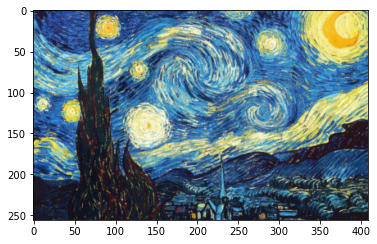

In [4]:
def load_image(path, size=256):
    img = PIL.Image.open(path)
    img = img.convert("RGB")
    img = torchvision.transforms.Resize(size)(img)
    return np.asarray(img).astype("float32") / 255.0


plt.imshow(load_image("../data/images/starry_night.jpg"))
plt.grid(False)

In [5]:
class StyleTransferNet(object):
    def __init__(
        self,
        style_layers,
        content_layers,
        vgg_model="vgg19",
        content_weight=5e0,
        style_weight=1e2,
    ):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()

    def capture_content(self, x):
        content_layers = self.vgg.multi_layer_activations(x, self.content_layers)
        self.content_captures = [l.detach() for l in content_layers]

    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(x, self.style_layers)
        self.style_captures = [self._gram_mat(l).detach() for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(x, needed_layers)
        content_values = needed_values[: len(self.content_layers)]
        style_values = needed_values[len(self.content_layers) :]

        self.content_losses = [
            self.mse(content_value, content_capture)
            for content_value, content_capture in zip(content_values, self.content_captures)
        ]
        self.style_losses = [
            self.mse(self._gram_mat(style_value), style_capture)
            for style_value, style_capture in zip(style_values, self.style_captures)
        ]

        loss = sum(self.content_losses) * self.content_weight
        loss = loss + sum(self.style_losses) * self.style_weight

        return loss

    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        b, c, w, h = x.size()
        x_ = x.view(b * c, w * h)
        G = torch.mm(x_, x_.t())
        return G.div(w * h).view(b, c, c)

Iteration    250 | loss  0.0067949


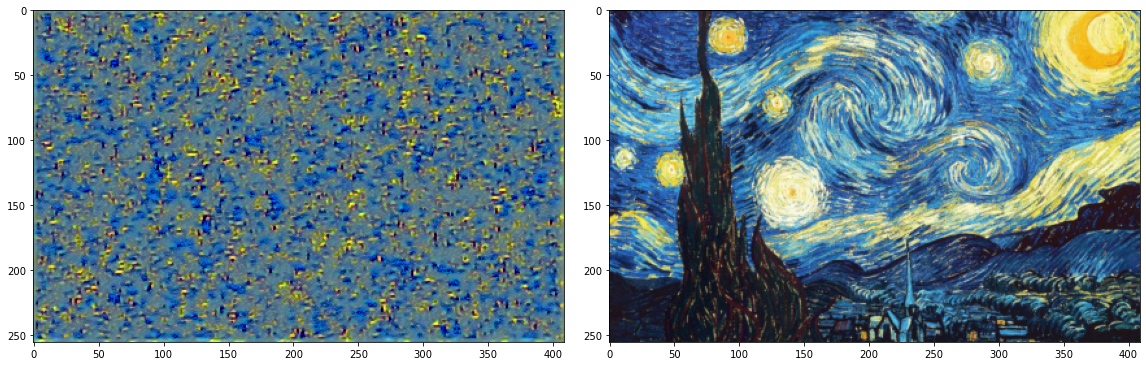

In [16]:
model = StyleTransferNet(
    style_layers=["conv1_1"],
    style_weight=1e1,
    content_layers=[],
    content_weight=0,
)

if CUDA:
    model.vgg.cuda()
    
style_img_path = "../data/images/starry_night.jpg"

style_img_size = 256

style_image = load_image(style_img_path, style_img_size)

print("Capturing style")
model.capture_style(to_tensor(style_image))

# image = load_image(content_img_path, 512)
image = np.random.randn(*style_image.shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

optimizer = torch.optim.Adam([image], lr=0.01)
# optimizer = torch.optim.LBFGS([image])

from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(122).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(121)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

Iteration    430 | loss  0.0203270


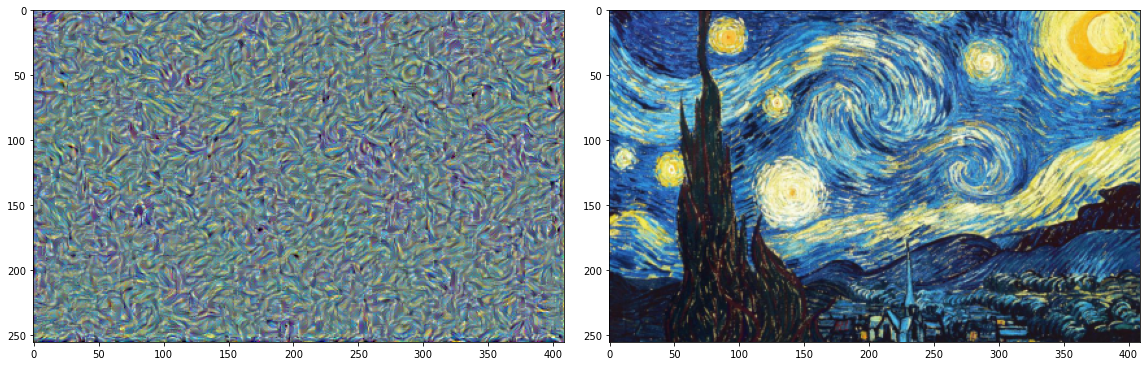

In [17]:
model = StyleTransferNet(
    style_layers=["conv2_1"],
    style_weight=1e1,
    content_layers=[],
    content_weight=0,
)

if CUDA:
    model.vgg.cuda()
    

style_img_path = "../data/images/starry_night.jpg"

style_img_size = 256

style_image = load_image(style_img_path, style_img_size)

print("Capturing style")
model.capture_style(to_tensor(style_image))

# image = load_image(content_img_path, 512)
image = np.random.randn(*style_image.shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

optimizer = torch.optim.Adam([image], lr=0.01)
# optimizer = torch.optim.LBFGS([image])

from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(122).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(121)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

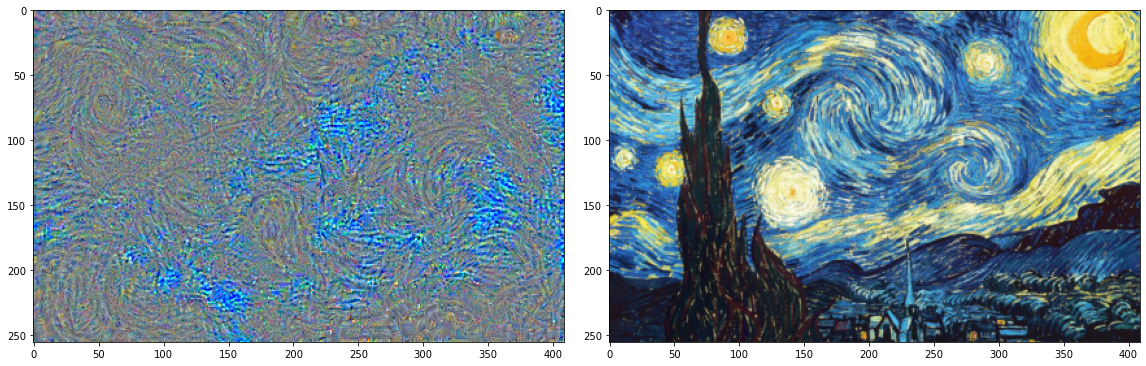

Iteration    495 | loss  0.1693531
  Style loss 1:     0.0484
  Style loss 2:     0.1210


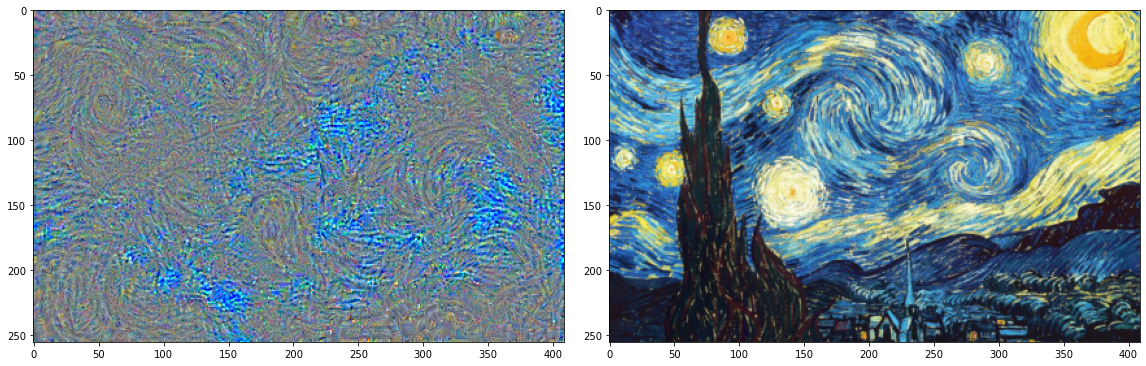

In [18]:
model = StyleTransferNet(
    style_layers=["conv1_1", "conv5_1"],
    style_weight=1e1,
    content_layers=[],
    content_weight=0,
)

if CUDA:
    model.vgg.cuda()
    

style_img_path = "../data/images/starry_night.jpg"

style_img_size = 256

style_image = load_image(style_img_path, style_img_size)

print("Capturing style")
model.capture_style(to_tensor(style_image))

# image = load_image(content_img_path, 512)
image = np.random.randn(*style_image.shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

optimizer = torch.optim.Adam([image], lr=0.01)
# optimizer = torch.optim.LBFGS([image])

from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(122).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(121)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

Iteration    253 | loss  0.0064381


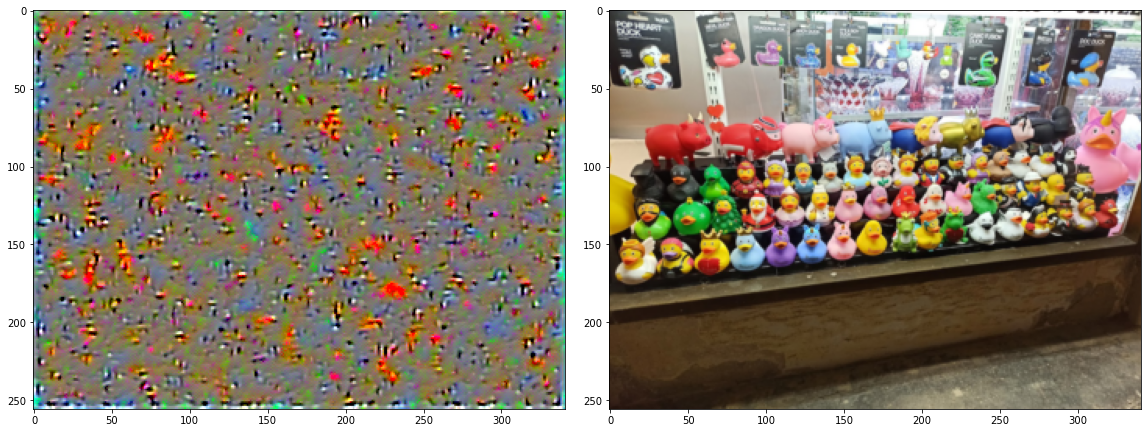

In [20]:
model = StyleTransferNet(
    style_layers=["conv1_1"],
    style_weight=1e1,
    content_layers=[],
    content_weight=0,
)

if CUDA:
    model.vgg.cuda()
    

style_img_path = "../data/new_images/IMG_20200216_193310.jpg"

style_img_size = 256

style_image = load_image(style_img_path, style_img_size)

print("Capturing style")
model.capture_style(to_tensor(style_image))

# image = load_image(content_img_path, 512)
image = np.random.randn(*style_image.shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

optimizer = torch.optim.Adam([image], lr=0.01)
# optimizer = torch.optim.LBFGS([image])

from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(122).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(121)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))

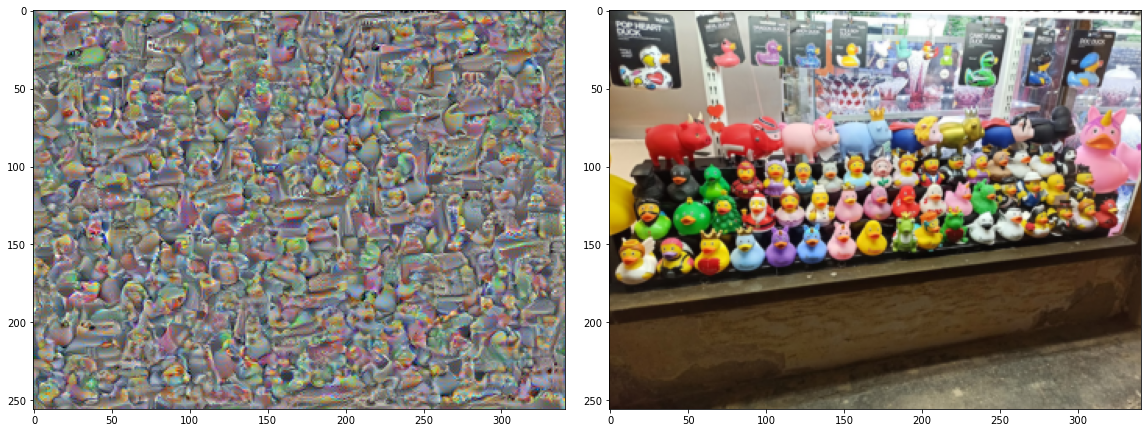

Iteration    475 | loss  0.4689469
  Style loss 1:     0.0666
  Style loss 2:     0.4023


In [ ]:
model = StyleTransferNet(
    style_layers=["conv1_1", "relu3_1"],
    style_weight=1e1,
    content_layers=[],
    content_weight=0,
)

if CUDA:
    model.vgg.cuda()
    

style_img_path = "../data/new_images/IMG_20200216_193310.jpg"

style_img_size = 256

style_image = load_image(style_img_path, style_img_size)

print("Capturing style")
model.capture_style(to_tensor(style_image))

# image = load_image(content_img_path, 512)
image = np.random.randn(*style_image.shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

optimizer = torch.optim.Adam([image], lr=0.01)
# optimizer = torch.optim.LBFGS([image])

from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(122).imshow(style_image)
    plt.grid(False)
    ax = fig.add_subplot(121)

    plt.tight_layout()
    imsh = ax.imshow(to_np(image))
    plt.grid(False)
    for iter_ in range(max_iters):

        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        image.data = image.data.clip_(0, 1)

        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)

            print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))
            for i, l in enumerate(model.content_losses):
                print(
                    "  Content loss {}: {: >8.4f}".format(
                        i + 1, l.item() * model.content_weight
                    )
                )
            for i, l in enumerate(model.style_losses):
                print(
                    "  Style loss {}: {: >10.4f}".format(
                        i + 1, l.item() * model.style_weight
                    )
                )

        old_loss = loss.item()
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print("Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item()))